# Прогнозирование продаж на год

## Данные

В наличии были следующие данные о видеоиграх:
- год издания
- платформа
- жанр
- возрастной рейтинг
- оценка пользователей
- оценка критиков
- регион
- количество продаж

## Шаг 1. Изучение общей информации в файлах  данными.

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem()
from collections import Counter
import seaborn as sns



game_data = pd.read_csv('/datasets/games.csv')
print(game_data.head())
print()
print(game_data.info())
print('количество дубликатов', game_data.duplicated().sum())

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11

Есть пропуски с годом - скорее всего, нет данных о  годе выхода игры.
Пропуски с оценками и рейтингом - нет информации, еще не посчитали на момент составления отчета(tbd), игра может быть малоизвестной, поэтому её никто не оценивал.
Дубликаты отсутствуют.

## Шаг 2. Подготовка данных


In [2]:
# приведем столбцы к нижнему регистру
game_data.columns = game_data.columns.str.lower()
game_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Названия столбцов приведены к нижнему регистру.

In [3]:
game_data['year_of_release'] = game_data['year_of_release'].astype('Int64')
game_data['user_score'] = pd.to_numeric(game_data['user_score'], errors = 'coerce')
print(game_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null Int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB
None


Столбец year_of_release приведен к целочисленным значениям. Столбец user_score приведен к float. Значения tbd из-за принудительного перевода превратились в NaN.

In [4]:
game_data.dropna(subset=['name'], inplace=True)
game_data.reset_index(drop=True)

for platform in game_data['platform'].unique():
    user_filter = game_data['user_score'].isna() & (game_data['platform'] == platform)
    game_data.loc[user_filter, 'user_score'] = game_data.loc[game_data['platform'] == platform, 'user_score'].median()
    
for platform in game_data['platform'].unique():
    critic_filter = game_data['critic_score'].isna() & (game_data['platform'] == platform)
    game_data.loc[critic_filter, 'critic_score'] = game_data.loc[game_data['platform'] == platform, 'critic_score'].median()
    
    
print(game_data.info())

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null Int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       15595 non-null float64
user_score         15595 non-null float64
rating             9949 non-null object
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB
None


Пропуски с названиями удалены.
Т.к. для пропусков с годом нет корректных замен(менять на среднее\медиану некорректно, на разных платформах одна игра могла выходить в разное время) - оставляем.
Оценки меняем на медианное значение в зависимости от платформы.
Рейтинг принимает только буквенные значение, нельзя заменить на среднее\медиану, 0 т - оставляем пропуски как есть.



In [5]:
game_data['sales_total'] = game_data['na_sales'] + game_data['eu_sales'] + game_data['jp_sales'] + game_data['other_sales']
game_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,73.0,7.1,NaN,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,71.0,7.0,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.0,7.6,NaN,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,69.0,8.0,NaN,0.01


Столбец с общими продажами добавлен.

## Шаг 3. Исследовательский анализ данных

In [6]:
releases_by_year = game_data.pivot_table(index='year_of_release', values='name', aggfunc=['count'])
releases_by_year

,count
,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16


Пик продаж был в 2006-2011г, возможно связано с одновременным выходом нескольких платформ.
После 2011г продажи упали примерно в 2 раза, но держатся примерно на одном уровне.

In [7]:
sales_by_platform=game_data.pivot_table(index='platform', values='sales_total', aggfunc=['sum'])
print(sales_by_platform.sort_values(by=[('sum', 'sales_total')], ascending=False))
top_platforms=pd.Series(['PS2','X360','PS3','Wii','DS','PS','GBA','PS4','PSP','PC'])

                 sum
         sales_total
platform            
PS2          1255.77
X360          971.42
PS3           939.65
Wii           907.51
DS            806.12
PS            730.86
GBA           317.85
PS4           314.14
PSP           294.05
PC            259.52
3DS           259.00
XB            257.74
GB            255.46
NES           251.05
N64           218.68
SNES          200.04
GC            198.93
XOne          159.32
2600           96.98
WiiU           82.19
PSV            54.07
SAT            33.59
GEN            28.35
DC             15.95
SCD             1.86
NG              1.44
WS              1.42
TG16            0.16
3DO             0.10
GG              0.04
PCFX            0.03


Топ-10 платформ по суммарным продажам игр за всё время:PS2, X360, PS3, Wii, DS, PS, GBA, PS4, PSP, PC

Продажи топ-10 платформ за всё время с разбивкой по годам.

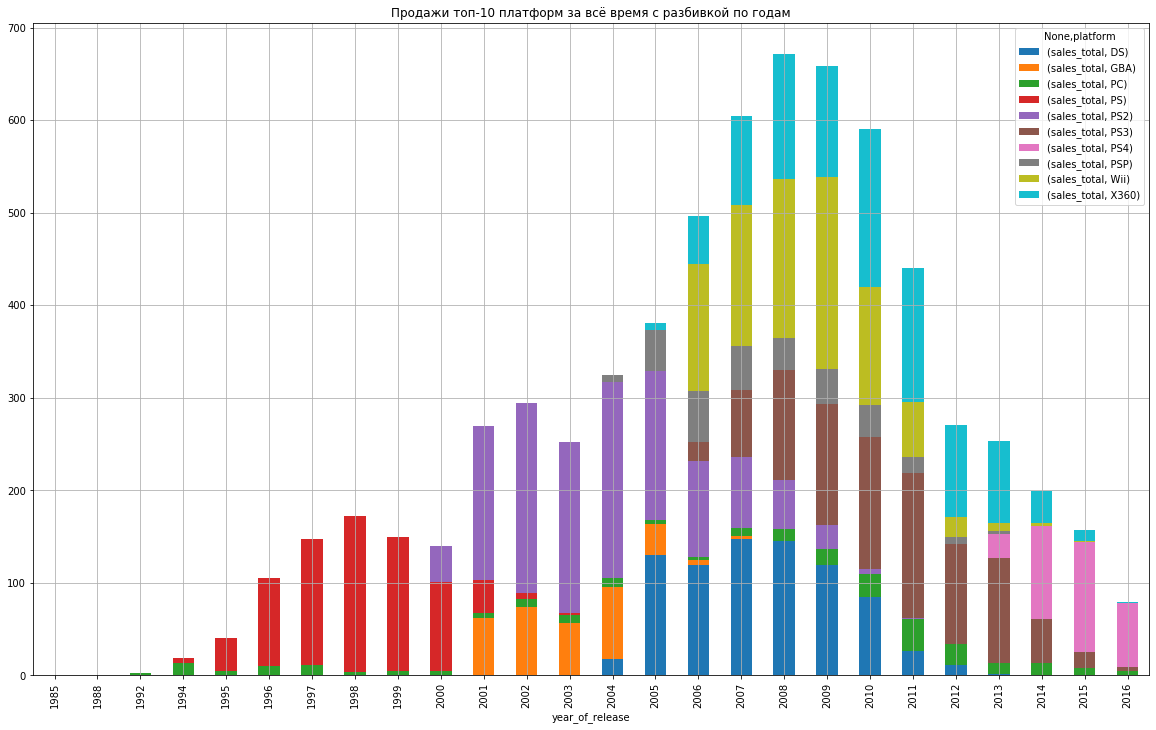

In [8]:
top_platforms_by_year=game_data.query('platform in @top_platforms')
top_platforms_by_year=top_platforms_by_year.groupby(['year_of_release', 'platform']).agg({'sales_total':'sum'}).unstack()

top_platforms_by_year.plot(kind='bar', figsize=(20,12), title='Продажи топ-10 платформ за всё время с разбивкой по годам', grid=True, stacked=True)



Средний срок жизни платформы 6 лет( уход из трендов и появление новой).
Рассчитывавем на след.год(2017), то считаем актуальным период 2012-2016(период 2011 - 2016 считаем завершенным, тк прошло 6 лет).

In [9]:
actual_game_data=game_data.query('year_of_release >= 2012')
actual_game_data=actual_game_data.reset_index(drop=True)
actual_game_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,73.0,7.0,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,68.0,7.1,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
2881,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.0,7.6,NaN,0.01
2882,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,71.0,7.6,NaN,0.01
2883,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,73.0,7.1,NaN,0.01
2884,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.0,7.6,NaN,0.01


Данные за актуальный период находятся в actual_game_data

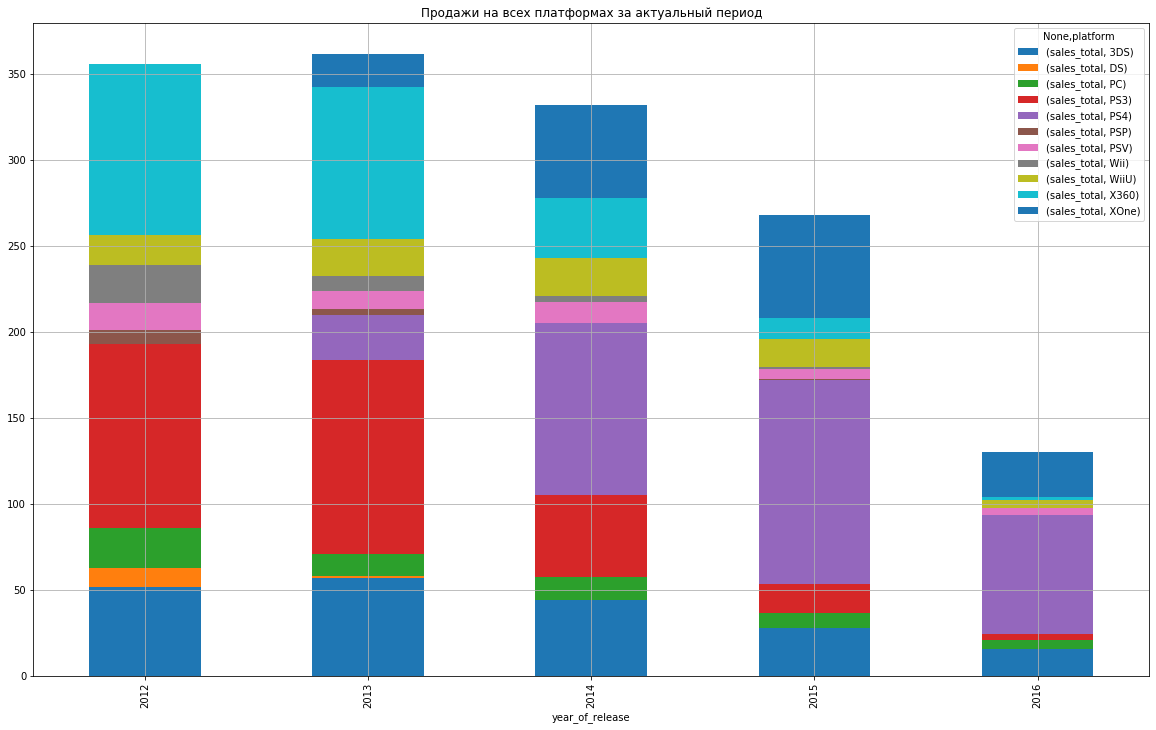

In [10]:
sales_by_year_actual=actual_game_data.groupby(['year_of_release', 'platform']).agg({'sales_total':'sum'}).unstack()

sales_by_year_actual.plot(kind='bar', figsize=(20,12), title='Продажи на всех платформах за актуальный период', grid=True, stacked=True)


Продажи в целом снижаются от года к году.
Лидирующими платформами являются PS3 и Xbox360 по количеству продаж в целом, однако это уже устаревшие платформы, чьи продажи резко упали в 2015.
Они уступили место PS4 и Xbox one  соответственно, чьи продажи растут(по состоянию на 2015).
Вывод: PS4 и Xbox one являются самыми перспективными платформами.

In [11]:
game_by_platform_actual = actual_game_data.groupby(['name', 'platform']).agg({'sales_total':'sum'})
game_by_platform_actual = game_by_platform_actual.reset_index()

sales_by_game_actual = actual_game_data.groupby(['name']).agg({'sales_total':'sum'})
sales_by_game_actual = sales_by_game_actual.reset_index()

mean_sales_by_platform_actual = actual_game_data.groupby(['platform']).agg({'sales_total':'mean'})
mean_sales_by_platform_actual = mean_sales_by_platform_actual.reset_index()

game_by_platform_actual - распределение продаж с разбивкой по играм и платформам.
sales_by_game_actual - глобальное распределение продаж по играм.
mean_sales_by_platform_actual - распеределение продаж в среднем по платформам.

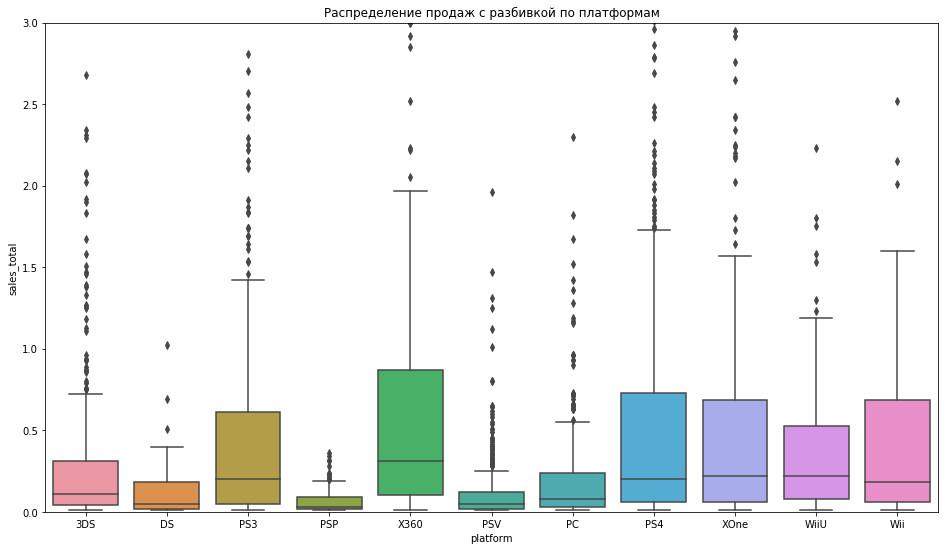

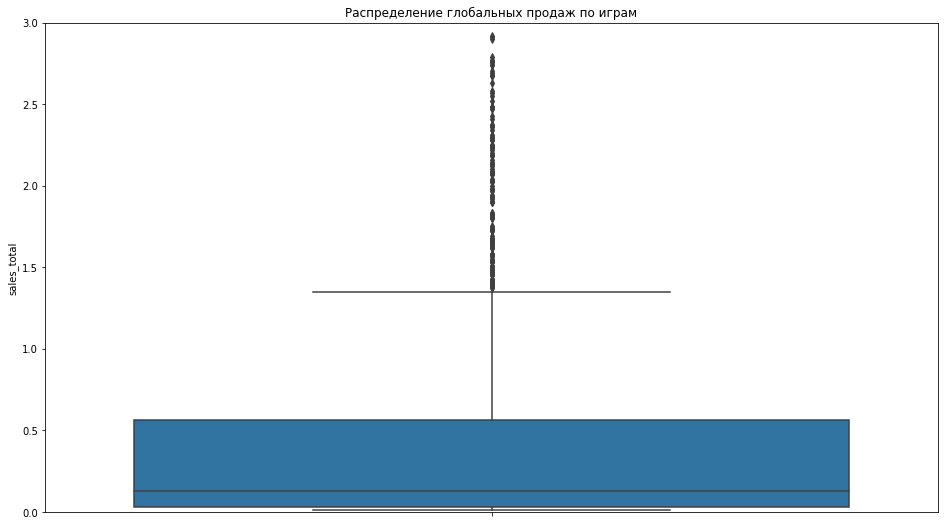

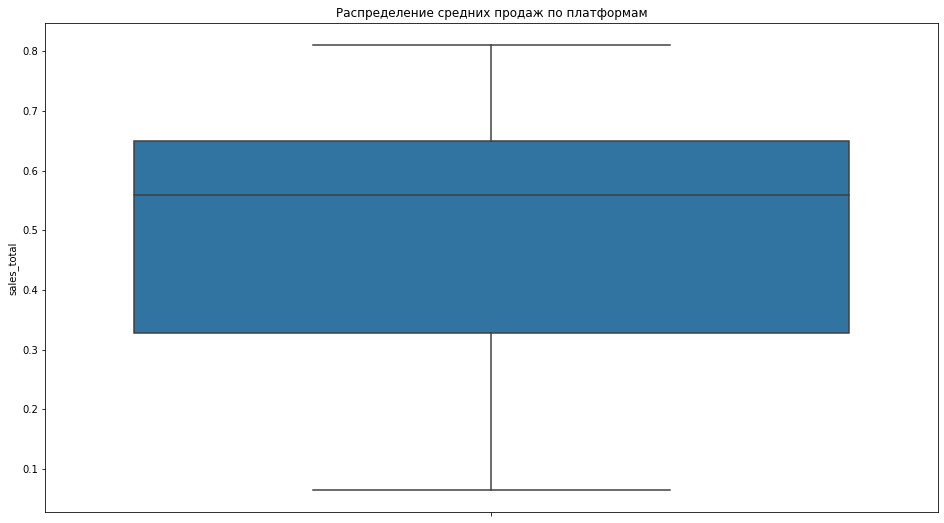

In [12]:
plt.figure(figsize=(16, 9))
plt.ylim(0, 3)
plt.title('Распределение продаж с разбивкой по платформам')
a1=sns.boxplot(x='platform', y='sales_total', data=game_by_platform_actual)

plt.figure(figsize=(16, 9))
plt.ylim(0, 3)
plt.title('Распределение глобальных продаж по играм')
a2=sns.boxplot(y='sales_total', data=sales_by_game_actual)

plt.figure(figsize=(16, 9))
plt.title('Распределение средних продаж по платформам')
a3=sns.boxplot(y='sales_total', data=mean_sales_by_platform_actual)


Вывод: наибольший уровень продаж у Xbox360, однако платформа устарела, и уровень продаж высокий только из-за хорошего старта.
Следом идут Xbox one и PS4. Меньше всего продаж у PSP и PSV.
В целом, продажи по платформам совпадают с глобальной продажей по играм -- медиана в этих разбивках находится примерно на уровне 0,1 - 0,5 млн.
Однако, средние продажи по всем платформам выше, чем глобальные продажи по играм - медиана > 0,5.
Это связано с неоднородностью платформ(есть топы: Xbox one и PS4, есть аутсайдеры PSP и PSV, разница в продажах примерно в 2 раза).

In [13]:
user_score_sales_relation = actual_game_data.groupby(['platform', 'user_score']).agg({'sales_total':'sum'})
user_score_sales_relation = user_score_sales_relation.reset_index()




critic_score_sales_relation = actual_game_data.groupby(['platform', 'critic_score']).agg({'sales_total':'sum'})
critic_score_sales_relation = critic_score_sales_relation.reset_index()

- *user_score_sales_relation* - отношение отзывов пользователей на продажи по всем платформам.
- *critic_score_sales_relation* - отношение отзывов критиков на продажи по всем платформам.

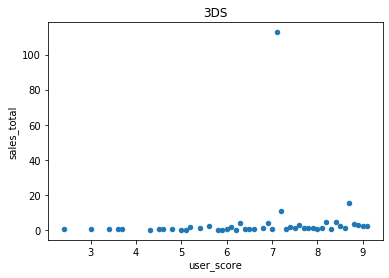

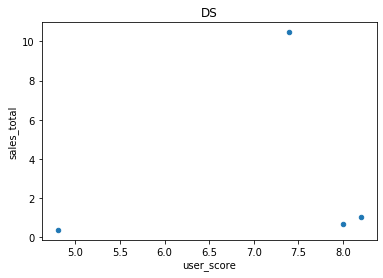

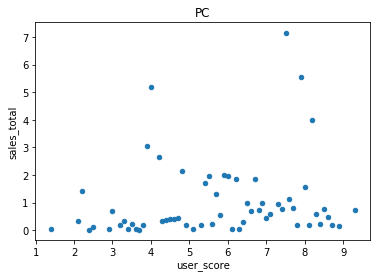

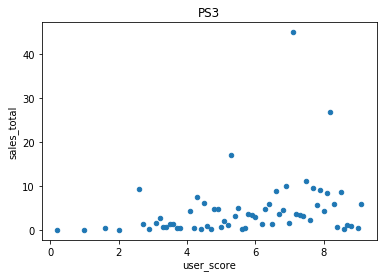

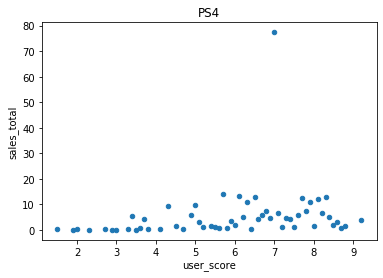

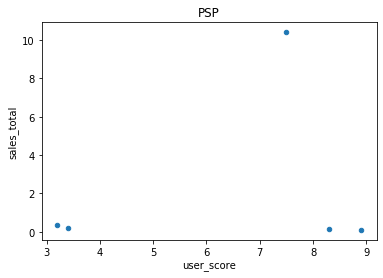

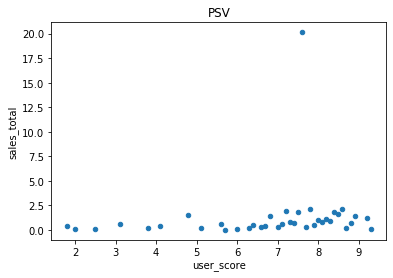

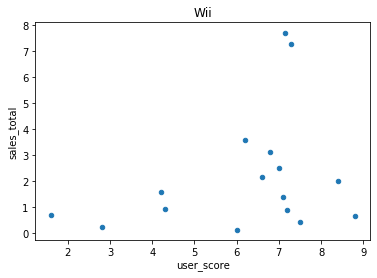

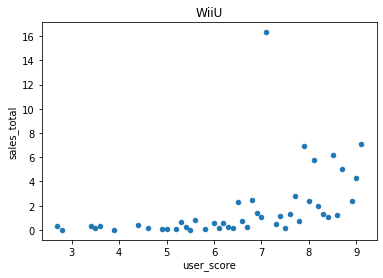

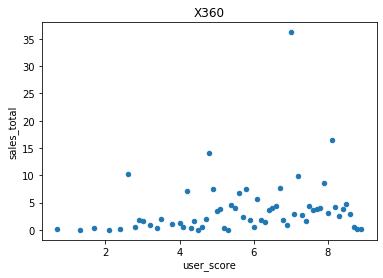

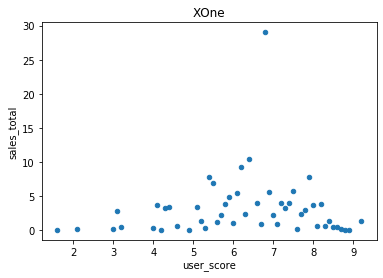

In [14]:
for name,group_data in user_score_sales_relation.groupby('platform'):
    group_data.plot(x='user_score', y='sales_total', title=name, kind='scatter')

Оценки пользователей в целом не влияют на уровень продаж.
Зависимость наблюдается только в 2 случаях из 11(Wii и WiiU).

In [15]:
print('Корреляция между оценками пользователей и продажами:', user_score_sales_relation['user_score'].corr(user_score_sales_relation['sales_total']))

Корреляция между оценками пользователей и продажами: 0.14735494605677596


Уровень корреляции 0,14 подтверждает, что оценки пользователей в целом не влияют на уровень продаж.

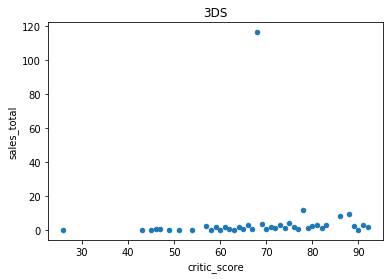

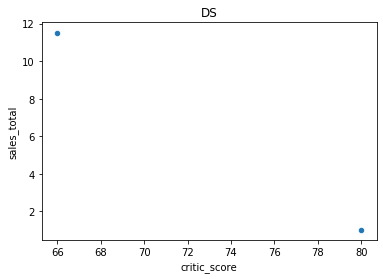

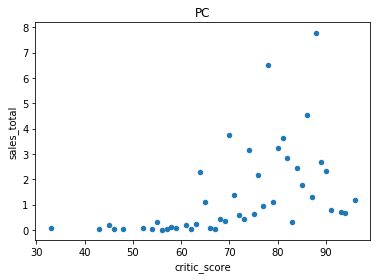

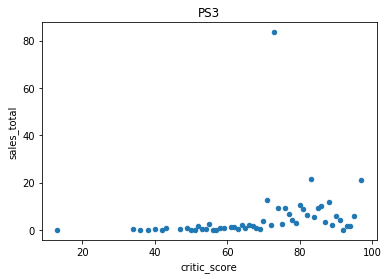

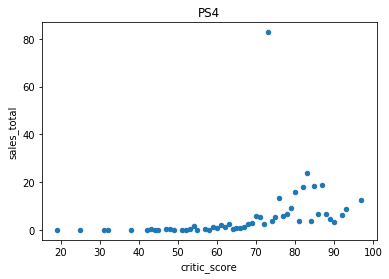

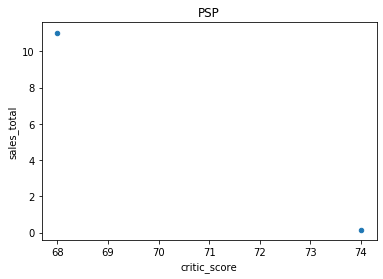

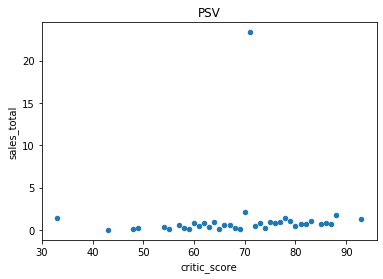

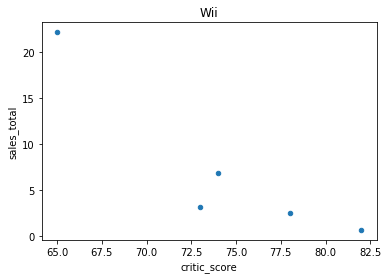

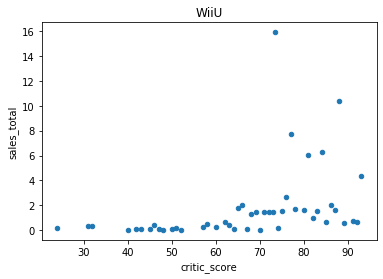

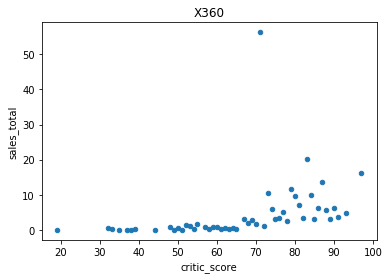

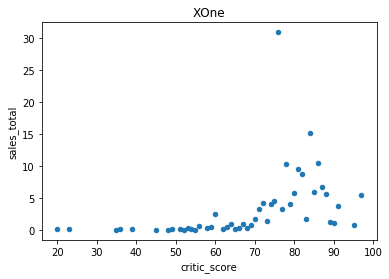

In [16]:
for name,group_data in critic_score_sales_relation.groupby('platform'):
    group_data.plot(x='critic_score', y='sales_total', title=name, kind='scatter')

Оценки критиков влияют на продажи сильнее, чем оценки пользователей, но всё еще не слишком сильно.
Зависимось в 6 случаях из 11.

In [17]:
print('Корреляция между оценками критиков и продажами:', critic_score_sales_relation['critic_score'].corr(critic_score_sales_relation['sales_total']))

Корреляция между оценками критиков и продажами: 0.22406179423360817


Корреляция выше, чем с оценками пользователей, но всё еще не слишком высокая.

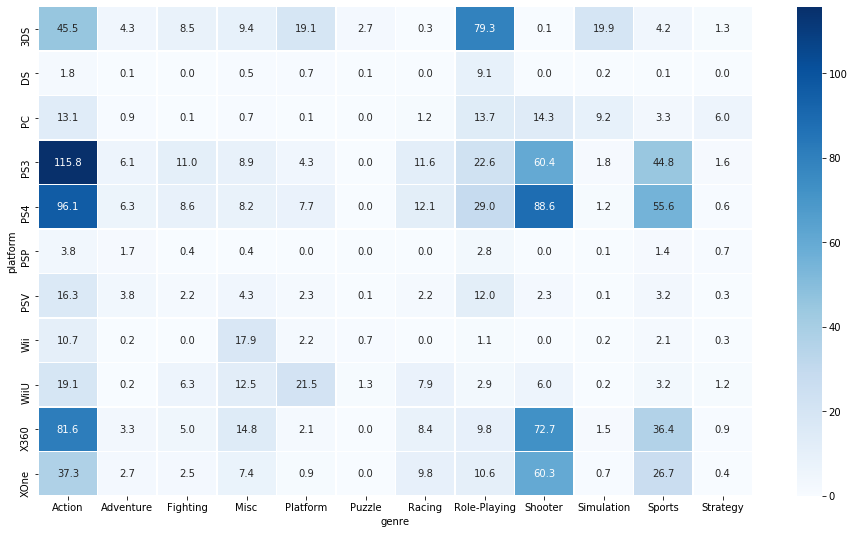

In [18]:
platform_genre_sales = actual_game_data.pivot_table(
                        index='platform', 
                        columns='genre', 
                        values='sales_total', 
                        aggfunc=sum).fillna(0)#заменим пропуски на 0

plt.figure(figsize=(16, 9))
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5, cmap="Blues")

Топ-3 самых прибыльных жанра почти на всех платформах - Action, Shooter, Sports.
Самые непопулярные Puzzle, Strategy.
Связано с тем, что игры жанра Action, Shooter, Sports достаточно просто портировать с платформы на платформу, а, например, стратегии представлены в основном только на ПК.

## Шаг 4. Портрет пользователя каждого региона

In [19]:
def region_stat(sales):
    region_platforms=actual_game_data.pivot_table(index='platform', values=sales, aggfunc=['sum'])
    print('Топ-5 платформ')
    print(region_platforms.sort_values(by=[('sum', sales)], ascending=False).head())
    region_genres=actual_game_data.pivot_table(index='genre', values=sales, aggfunc=['sum'])
    print()
    print()
    print('Топ-5 жанров')
    print(region_genres.sort_values(by=[('sum', sales)], ascending=False).head())


Функция для вывода Топ-5 платформ и Топ-5 жанров в зависимости от региона.

In [20]:
region_stat('na_sales')

Топ-5 платформ
              sum
         na_sales
platform         
X360       140.05
PS4        108.74
PS3        103.38
XOne        93.12
3DS         55.31


Топ-5 жанров
                  sum
             na_sales
genre                
Action         177.84
Shooter        144.77
Sports          81.53
Role-Playing    64.00
Misc            38.19


Топ-5 платформ и Топ-5 жанров в Северной Америке совпадают с самыми популярными платформами и жанрами в целом по миру.
Разница между топ-4 платформами не очень значительна, сильно отстает только 3DS. Топ-1 платформа Xbox 360. связано с тем, что Xbox американская платформа, отсюда популярность\доступность.
С жанрами ситуация иная: топ-2 жанра(action, shooter) популярнее остальных примерно в 2 раза, на эти 2 жанра приходится больше продаж, чем на все остальные вместе взятые.

In [21]:
region_stat('eu_sales')

Топ-5 платформ
              sum
         eu_sales
platform         
PS4        141.09
PS3        106.86
X360        74.52
XOne        51.59
3DS         42.64


Топ-5 жанров
                  sum
             eu_sales
genre                
Action         159.34
Shooter        113.47
Sports          69.09
Role-Playing    48.53
Racing          27.29


Европейский регион почти такой же, как североамериканский. Топ-5 платформ и жанров такие же.
Самые популярные платформы PS4, PS3.
Единственное различие в жанрах - европейцы предпочитают гонки.
В целом, продажи ниже, чем в Северной Америке.

In [22]:
region_stat('jp_sales')

Топ-5 платформ
              sum
         jp_sales
platform         
3DS         87.79
PS3         35.29
PSV         21.04
PS4         15.96
WiiU        13.01


Топ-5 жанров
                  sum
             jp_sales
genre                
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44


Японский регион сильно отличается от остальных.
Топ-5 платформ все японские.
Топ-5 жанров совершенно другой - японцы предпочитают ролевые игры и файтинги.
Уровень продаж самый низкий из 3х регионов.

In [23]:
def rating_sales_relation(sales):
    rating_relation =  actual_game_data.pivot_table(
                        index='platform', 
                        columns='rating', 
                        values=sales, 
                        aggfunc=sum).fillna(0)
    plt.figure(figsize=(16, 9))
    plt.title('Влияние рейтинга в регионе на продажи')
    sns.heatmap(rating_relation, annot=True, fmt=".1f", linewidths=.5, cmap="Blues")




функция определения влияния рейтинга в регионе на продажи.

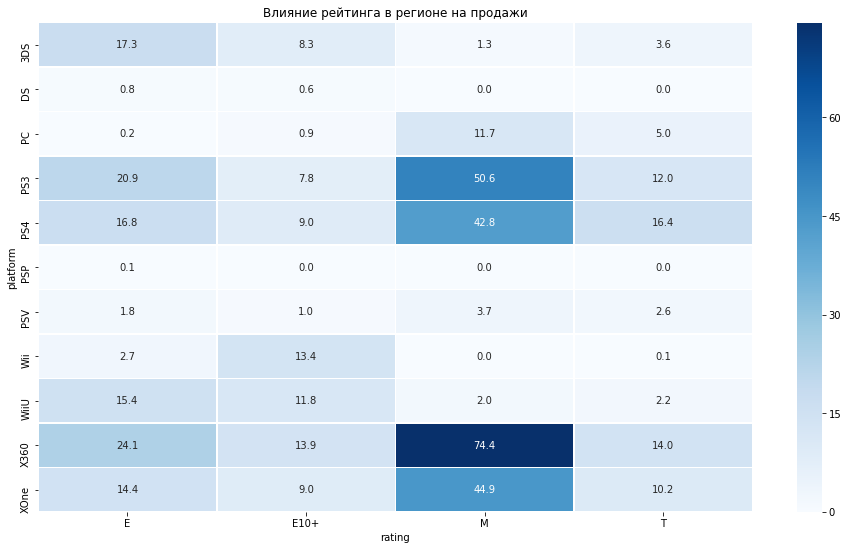

In [24]:
rating_sales_relation('na_sales')

В Северной Америке самый продающий рейтинг M.
Остальные рейтинги в целом на одном уровне.

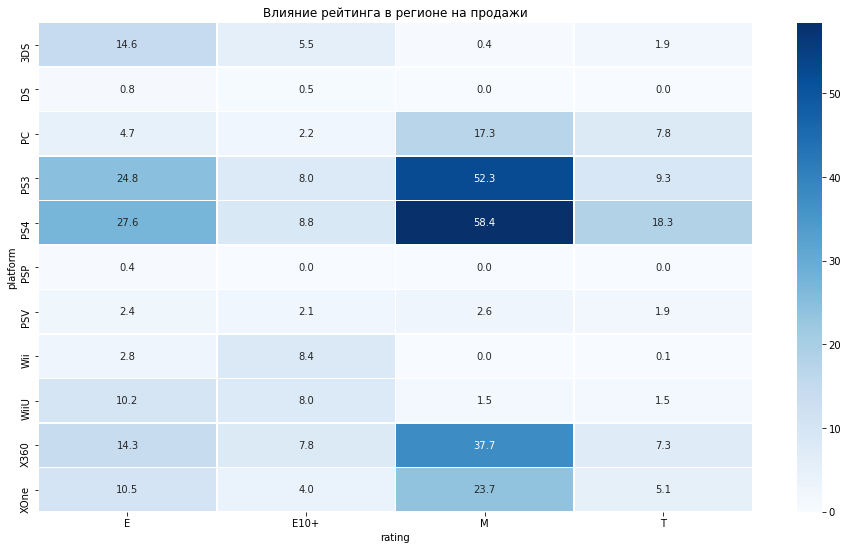

In [25]:
rating_sales_relation('eu_sales')

Европейский регион слегка отличается.
Самые популярные рейтинги M и E.


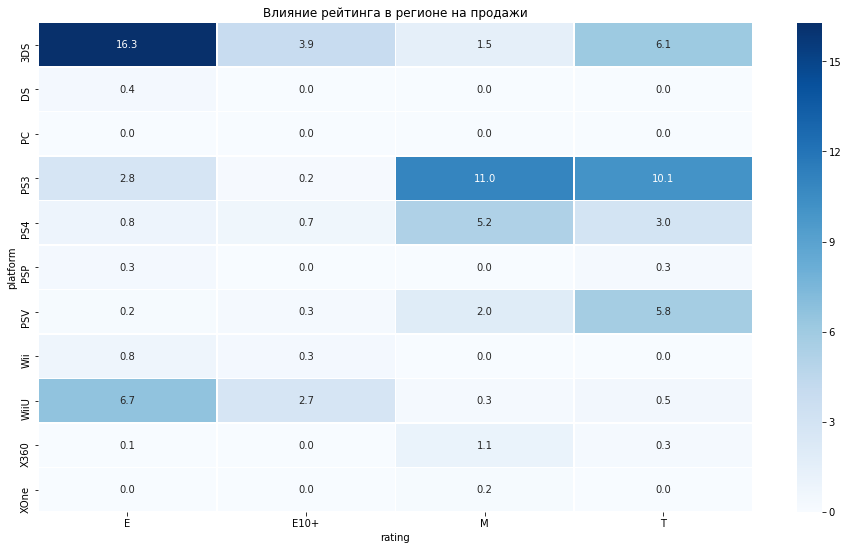

In [26]:
rating_sales_relation('jp_sales')

В Японии самые популярные рейтинг M и T.
Есть пик в рейтиге E у платформы 3DS, но это связано со спецификой платформы.

Вывод: рейтинг M самый популярный во всех регионах на всех платформах.
Игр с таким рейтингом продано больше всего.
Рейтинг ESRB влияет на продажи.

## Шаг 5. Проверка гипотез

Разбивка продаж по платформам.

In [27]:
mean_user_score_xone = actual_game_data.query('platform == "XOne"')
mean_user_score_pc = actual_game_data.query('platform == "PC"')

xone_score = mean_user_score_xone['user_score']
pc_score = mean_user_score_pc['user_score']

alpha = .05

results = st.ttest_ind(
    xone_score, 
    pc_score) # гипотеза что продажи xone и pc равны

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('addd')
print(xone_score)

p-значение: 0.8572721079249328
Не получилось отвергнуть нулевую гипотезу
addd
21      6.8
31      7.9
34      5.4
44      6.4
53      6.2
       ... 
2854    8.2
2858    6.6
2860    6.8
2867    6.7
2871    6.8
Name: user_score, Length: 247, dtype: float64


За нулевую гипотезу принимаем, что средние продажи на Xbox One и на PC равны.
Тк p-значение > alpha - принимаем нулевую гипотезу.
Продажи равны.

Разбивка продаж по жанрам.

In [28]:
mean_user_score_action = actual_game_data.query('genre == "Action"')
mean_user_score_sports = actual_game_data.query('genre == "Sports"')

action_score = mean_user_score_action['user_score']
sports_score = mean_user_score_sports['user_score']

alpha = .05

results = st.ttest_ind(
    action_score, 
    sports_score) # гипотеза что продажи action и sports равны

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0459173819750196e-38
Отвергаем нулевую гипотезу


За нулевую гипотезу принимаем, что средние продажи жанров action и sports равны.
Тк p-значение < alpha - отвергаем нулевую гипотезу.
Средние продажи жанров action и sports не равны.

## Шаг 6. Общий вывод

Продажи в целом идут на спад. Самые перспективные платформы PS4, Xbox one.
Меньше всего продаж у PSP и PSV. В целом, продажи по платформам совпадают с глобальной продажей по играм -- медиана в этих разбивках находится примерно на уровне 0,1 - 0,5 млн. Однако, средние продажи по всем платформам выше, чем глобальные продажи по играм - медиана > 0,5. Это связано с неоднородностью платформ(есть топы: Xbox one и PS4, есть аутсайдеры PSP и PSV, разница в продажах примерно в 2 раза).
Оценки пользователей не влияют на продажи.
Оценки критиков влияют.
Североамериканский и европейский регионы одинаковые(одинаковые топ-ы платформ и жанров).
Японский регион самый самобытный(другой топ платформ и жанров).
Североамериканский регион самый прибыльный.
Японский наименее прибыльный.
Самый популярный рейтинг во всех регионах на всех платформах M.

Cредние продажи на Xbox One и на PC равны.
Средние продажи жанров action и sports не равны.